In [485]:
import pybedtools as pbt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from Bio import Align, SeqIO, Seq
import numpy as np
from collections import defaultdict
import treeswift as ts

pd.set_option('display.max_rows', 150)

In [481]:
taxdict = {}
taxonomy_tree = ts.read_tree_newick('../data/metazoan_taxonomy.nwk')

tax_groups = ['Ctenophora', 
             'Hemichordata', 
             'Bryozoa', 
             'Rotifera', 
             'Chordata', 
             'Echinodermata', 
             'Arthropoda', 
             'Mollusca', 
             'Annelida', 
             'Nematoda', 
             'Platyhelminthes',
             'Cnidaria']

for tax in tax_groups:
    for node in taxonomy_tree.root.traverse_bfs():
        if node[0].label.strip("'") == tax:
            for i in node[0].traverse_leaves():
                taxdict[i.label.strip("'").replace(' ', '_')] = tax 
                

metadata_df = pd.read_csv('../data/parsed_metazoans.out', 
                          sep='\t', 
                          header=None, 
                          names=['species', 'genome', 'ftpdir', 'scaffold_n50', 'assembly_status']) \
                .drop(['ftpdir', 'genome'], axis=1)
metadata_df['genus'] = metadata_df['species'].apply(lambda x: x.split('_')[0])
metadata_df['taxonomy'] = metadata_df.species.apply(lambda x: taxdict.get(x, 'Other'))
metadata_df = metadata_df.loc[metadata_df.scaffold_n50 > 1e06]

znf_counts = []
for species in metadata_df.iterrows():
    try:
        znf_bed = pbt.BedTool(f'../data/beds/{species[1].species}_znfs.bed')
    except:
        print(f'{species[1].species} missing')
        
    for row in znf_bed:
        znf_counts.append((species[1].species, species[1].taxonomy, species[1].assembly_status, species[1].scaffold_n50, int(row[4])))
znf_count_df = pd.DataFrame(znf_counts, columns=['species', 'taxonomy', 'assembly_status', 'scaffold_n50', 'znf_count'])
print(znf_count_df)

Ambystoma_mexicanum missing
Muntiacus_muntjak missing
Neoceratodus_forsteri missing
Protopterus_annectens missing
                     species    taxonomy assembly_status  scaffold_n50  \
0       Abrostola_tripartita  Arthropoda      Chromosome      13645312   
1       Abrostola_tripartita  Arthropoda      Chromosome      13645312   
2       Abrostola_tripartita  Arthropoda      Chromosome      13645312   
3       Abrostola_tripartita  Arthropoda      Chromosome      13645312   
4       Abrostola_tripartita  Arthropoda      Chromosome      13645312   
...                      ...         ...             ...           ...   
614356          Mus_musculus       Other      Chromosome     106145001   
614357          Mus_musculus       Other      Chromosome     106145001   
614358          Mus_musculus       Other      Chromosome     106145001   
614359          Mus_musculus       Other      Chromosome     106145001   
614360          Mus_musculus       Other      Chromosome     106145001  

In [498]:
hiqual_df = znf_count_df.groupby(['species', 'taxonomy', 'assembly_status', 'scaffold_n50']).count().reset_index()
hiqual_df = hiqual_df.loc[(hiqual_df.assembly_status == 'Chromosome') & (hiqual_df.scaffold_n50 > 1e6) & (hiqual_df.znf_count > 500)].sort_values('znf_count')
print(hiqual_df.tail(150))

                                               species    taxonomy  \
664                                     Equus_caballus    Chordata   
1483                            Sphaeramia_orbicularis    Chordata   
455                                   Crotalus_viridis    Chordata   
1159                  Pachyrhynchus_sulphureomaculatus  Arthropoda   
347                                  Cervus_canadensis    Chordata   
1315                                 Propylea_japonica  Arthropoda   
1048                                    Mytilus_edulis    Mollusca   
1056                               Nematolebias_whitei    Chordata   
360                                     Chelonia_mydas    Chordata   
291                                 Callithrix_jacchus    Chordata   
472                                    Cydia_splendana  Arthropoda   
138                                 Apotomis_turbidana  Arthropoda   
924                                Macaca_fascicularis    Chordata   
158                 

In [423]:
distances = []
for species in rand_species:
    observed_distances, shuffled_distances = {}, {}
    observed_bed = pbt.BedTool(f'../data/beds/{species}_znfs.bed')
    shuffled_bed = observed_bed.shuffle(g=f'../data/genomes/{species}.genome').sort()
    closest_observed_bed = observed_bed.closest(observed_bed, io=True, d=True)
    closest_shuffled_bed = shuffled_bed.closest(shuffled_bed, io=True, d=True)

    for row in closest_observed_bed:
        key = tuple(sorted([(row[0], row[1], row[2]), (row[6], row[7], row[8])]))
        observed_distances[key] = int(row[-1])
    
    for row in closest_shuffled_bed:
        key = tuple(sorted([(row[0], row[1], row[2]), (row[6], row[7], row[8])]))
        shuffled_distances[key] = int(row[-1])
    
    distances += [(i, 'observed', species) for i in observed_distances.values() if i != -1]
    distances += [(i, 'expected', species) for i in shuffled_distances.values() if i != -1]
dist_df = pd.DataFrame(distances, columns=['distance', 'category', 'species'])
print(dist_df)

       distance  category             species
0         68655  observed    Eulithis_prunata
1        196568  observed    Eulithis_prunata
2        226202  observed    Eulithis_prunata
3       1577129  observed    Eulithis_prunata
4        591091  observed    Eulithis_prunata
...         ...       ...                 ...
14200    766040  expected  Toxotes_jaculatrix
14201    869462  expected  Toxotes_jaculatrix
14202    607433  expected  Toxotes_jaculatrix
14203     71398  expected  Toxotes_jaculatrix
14204   1625299  expected  Toxotes_jaculatrix

[14205 rows x 3 columns]


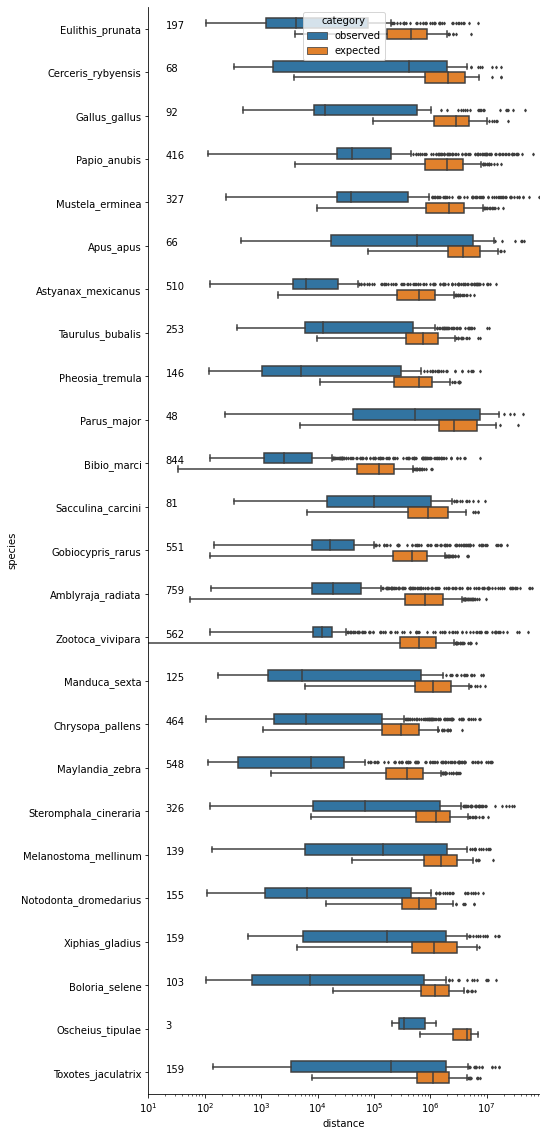

RanksumsResult(statistic=-64.94337594714256, pvalue=0.0)


In [432]:
fig, ax = plt.subplots(figsize=(7, 20))
sns.boxplot(data=dist_df, x='distance', y='species', hue='category', width=0.5, fliersize=2, ax=ax)

for i, species in enumerate(rand_species):
    ax.text(y=i, x=20, s=len(dist_df.loc[(dist_df.species == species) & (dist_df.category == 'observed')]))
ax.set_xscale('log')
ax.set_xlim(10, max(dist_df.distance))
sns.despine()
plt.show()
print(stats.ranksums(dist_df.loc[dist_df.category == 'observed', 'distance'],
                     dist_df.loc[dist_df.category == 'expected', 'distance']))

In [453]:
species_matrices = {}

In [493]:
def get_alignment_identity(ali):
    a1, a2 = str(ali).split('\n')[0], str(ali).split('\n')[2]
    return 100*len([val for (i, val) in enumerate(a1) if val == a2[i]])/len(a1)

species_list = ['Salvelinus_namaycush', 'Streblospio_benedicti', 'Bibio_marci']
for species in species_list:
    seqs = SeqIO.to_dict(SeqIO.parse(f'../data/seqs/{species}_znfs.fa', 'fasta'))

    observed_bed = []
    znf_chrom_dict = defaultdict(int)
    i = 0
    with open(f'../data/beds/{species}_znfs.bed') as infile:
        for line in infile:
            line = line.strip().split('\t')
            line[3] += f'-{i}'
            znf_chrom_dict[line[0]] += 1
            observed_bed.append(line)
            i += 1
    znf_chrom = sorted(znf_chrom_dict.items(), key=lambda x: x[1])[-1][0]
    observed_bed = pbt.BedTool(observed_bed)
    
    znf_chrom_bed = observed_bed.filter(lambda b: b.chrom == znf_chrom)
    znf_chrom_seqs = [f'{row[0]}:{row[1]}-{row[2]}({row[5]})' for row in znf_chrom_bed]

    aligner = Align.PairwiseAligner()
    aligner.mode = 'global'
    aligner.substitution_matrix = Align.substitution_matrices.load("BLOSUM62")

    mat = np.zeros((len(znf_chrom_seqs), len(znf_chrom_seqs)))
    print(species, znf_chrom, znf_chrom_dict[znf_chrom], int(hiqual_df.loc[hiqual_df.species == species, 'znf_count']))
    for i, vali in enumerate(sorted(znf_chrom_seqs, key=lambda x: int(x.split(':')[1].split('-')[0]))):
        for j, valj in enumerate(sorted(znf_chrom_seqs, key=lambda x: int(x.split(':')[1].split('-')[0]))):
            if i >= j:
                continue
            ali = aligner.align(seqs[vali].seq.translate(), seqs[valj].seq.translate())[0]
            mat[i][j] = get_alignment_identity(ali)
        if i%50 == 0:
            print(f'{i} out of {len(znf_chrom_seqs)}')
    print(print(f'{i} out of {len(znf_chrom_seqs)}'))
    species_matrices[species] = mat

Salvelinus_namaycush CM028282.1 141 3781


/Users/jonwells/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


0 out of 141
50 out of 141
100 out of 141
140 out of 141
None
Streblospio_benedicti CM032660.1 149 1807
0 out of 149
50 out of 149
100 out of 149
148 out of 149
None
Bibio_marci OU343119.1 860 1249
0 out of 860
50 out of 860
100 out of 860
150 out of 860
200 out of 860
250 out of 860
300 out of 860
350 out of 860
400 out of 860
450 out of 860
500 out of 860
550 out of 860
600 out of 860
650 out of 860
700 out of 860
750 out of 860
800 out of 860
850 out of 860
859 out of 860
None


In [494]:
print(np.mean(species_matrices['Salvelinus_namaycush']))

18.146576718350747


KeyError: ('Salvelinus_namaycush', 'Streblospio_benedicti', 'Bibio_marci')

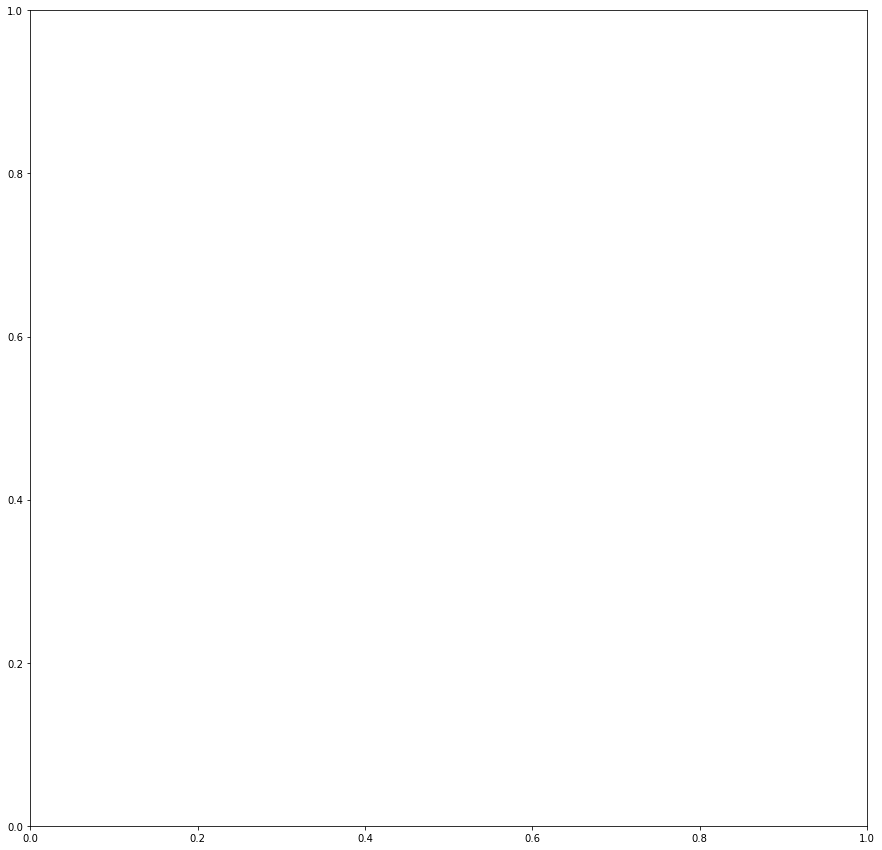

In [492]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(species_matrices['Salvelinus_namaycush', 'Streblospio_benedicti', 'Bibio_marci'], cmap='viridis', vmin=50)
plt.show()

In [385]:
ali = aligner.align(seqs['CM001000.3:3199674-3200475(+)'].seq.translate(), seqs['CM001000.3:4921710-4924893(+)'].seq.translate())[0]
a1, a2 = str(ali).split('\n')[0], str(ali).split('\n')[2]
print(len([val for (i, val) in enumerate(a1) if val == a2[i]])/len(a1))

0.1400709219858156


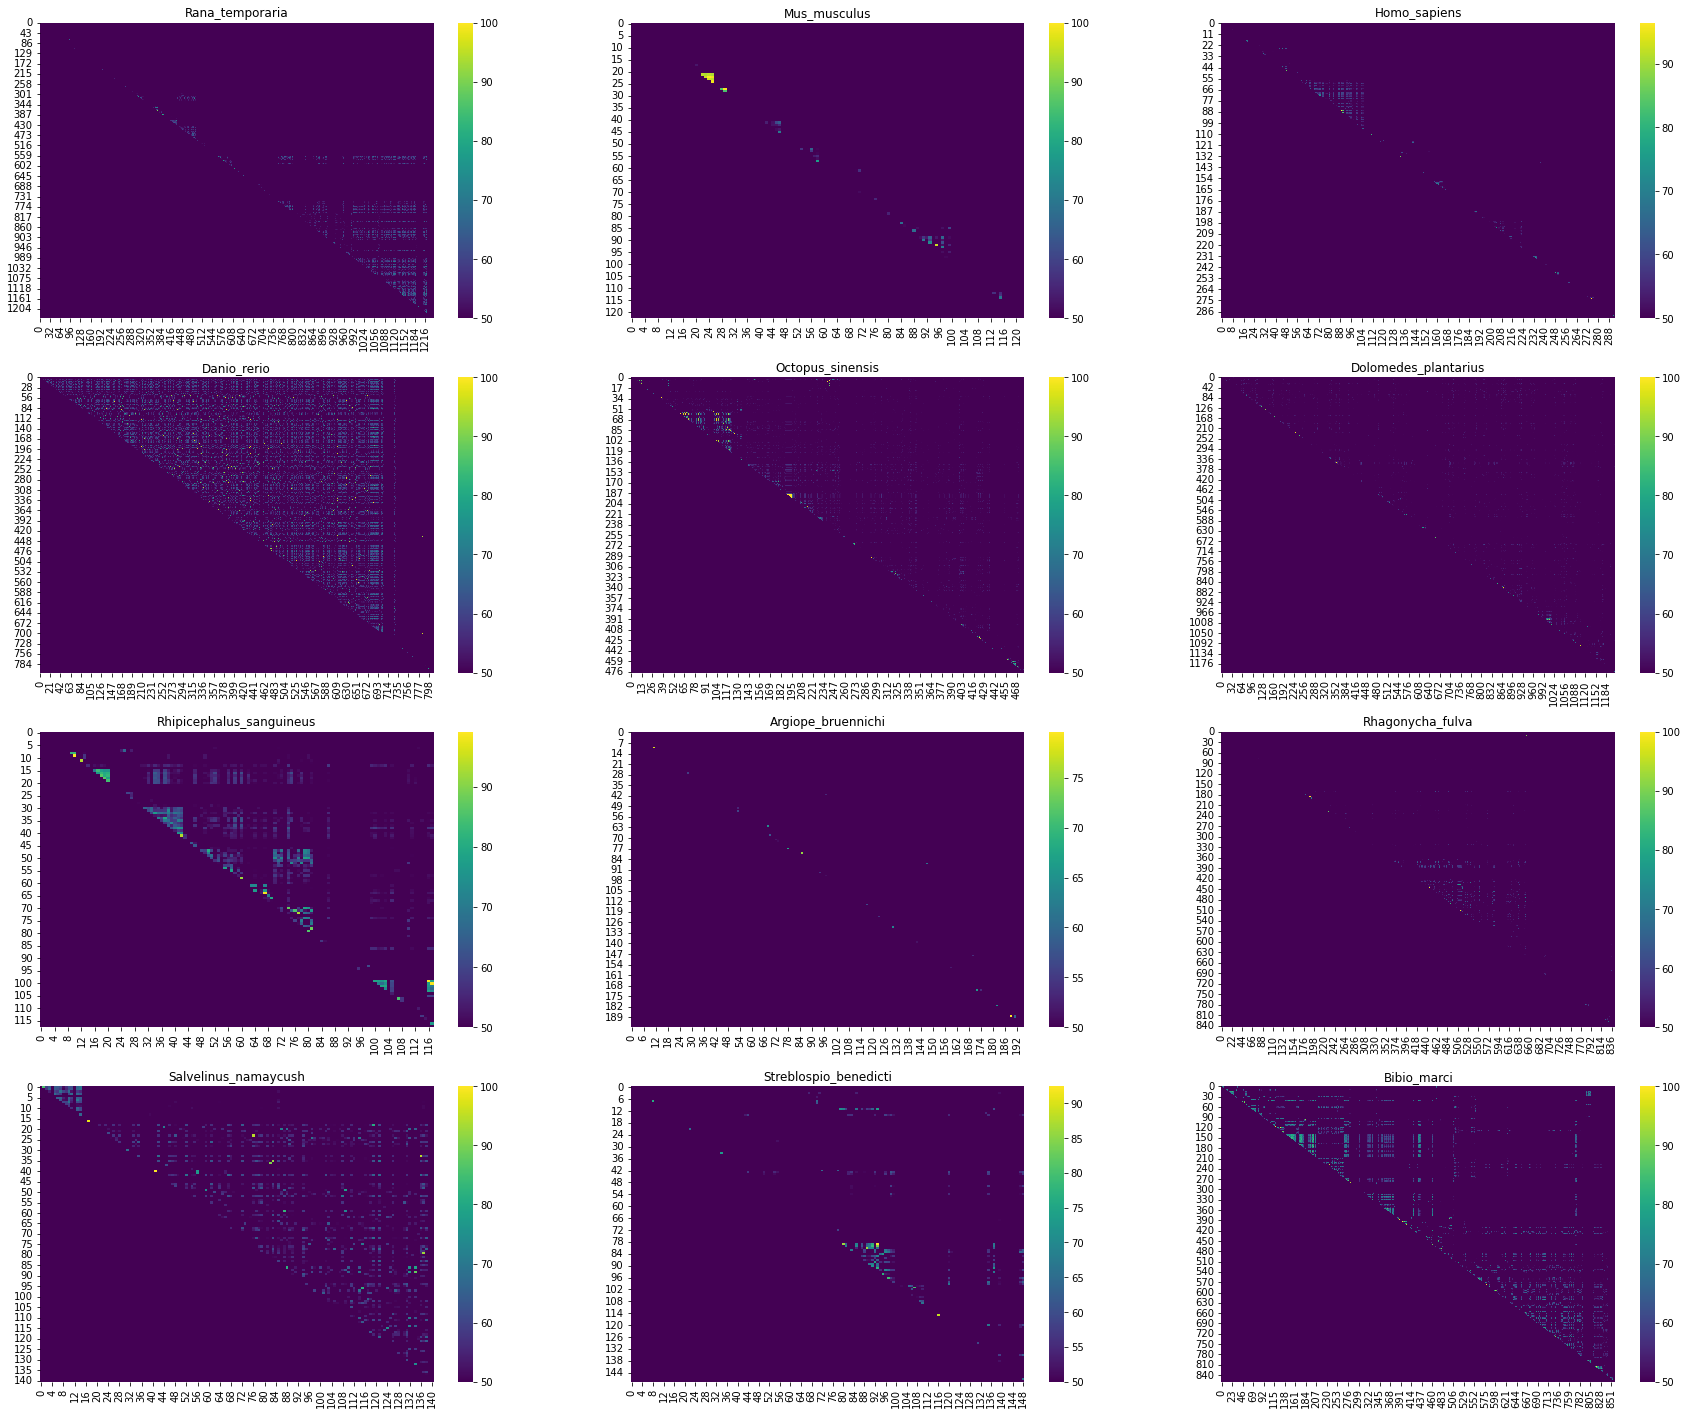

In [495]:
fig, axes = plt.subplots(figsize=(30, 25), nrows=4, ncols=3)
i, j = 0, 0
for species in species_matrices.keys():
    sns.heatmap(species_matrices[species], cmap='viridis', ax=axes[i][j], vmin=50)
    axes[i][j].set_title(species)
    j += 1
    if j > 2:
        i += 1
        j = 0
        
plt.show()